In [20]:
import numpy as np
import networkx as nx
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import imageio
import os
from qwalk_simulator_helper import(
    classical_random_walk, quantum_walk, print_state_vectors,
    plot_graph, get_probability_difference, visualize_probabilities,
    create_cayley_tree, plot_cayley_tree_central, create_wheel_graph, plot_wheel_graph, get_pi_frac)

### Define the Graph:
We can choose from the many NetworkX graph generators found at this link:

https://networkx.org/documentation/stable/reference/generators.html

We can specify any adjacency matrix, or build a graph using nx to directly add nodes and edges



In [2]:

# define any graph you'd like from the networkx library
G1 = nx.hypercube_graph(3)
G2 = nx.cycle_graph(10)
G3 = nx.grid_2d_graph(6, 6)
G4 = nx.balanced_tree(3,3)
G5 = nx.lollipop_graph(8,15)


# Or define a graph from an adjacency matrix (defined as an array) 
user_adj = np.array([
    [0,1,1,1,1,0,0],
    [1,0,1,1,1,0,0],
    [1,1,0,1,0,1,0],
    [1,1,1,0,1,1,1],
    [1,1,0,1,0,0,1],
    [0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0]
    ])

# Another option is to use networkx to define a method to generate any large size graph 


G6 = nx.from_numpy_array(user_adj)

# We can implement methods to generate graphs of particular interest
wheel_graph = create_wheel_graph(8)
caylay_graph = create_cayley_tree(3,4)

### To See What We're Dealing With, Let's First Plot Our Graph

Let's start with the Cayley tree, as it also has an efficient discrete walk implementation found in this paper:

https://journals.aps.org/pra/abstract/10.1103/PhysRevA.86.042338




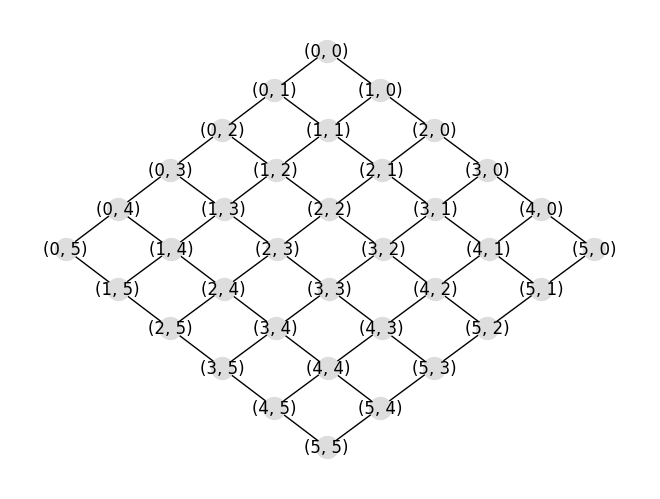

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


graph = G3
plot_graph(graph, labels=True)

#### ### It's time to put it all together and try out different things 
#### Note: At the bottom of the page, there is an attempt to simulate an interactive walk with a time slider. We still need to fix the bug that makes the figure not show.


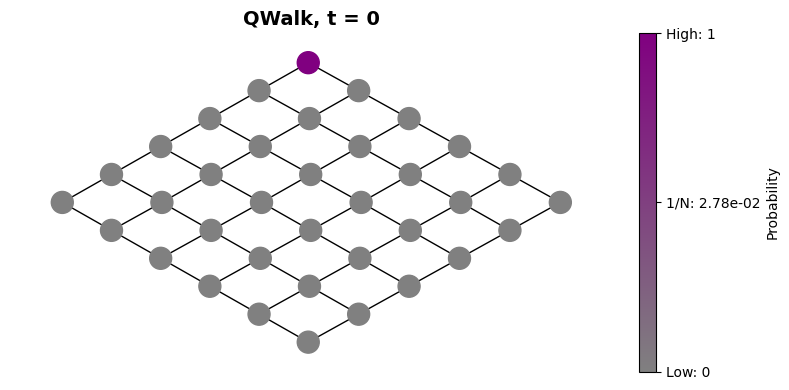

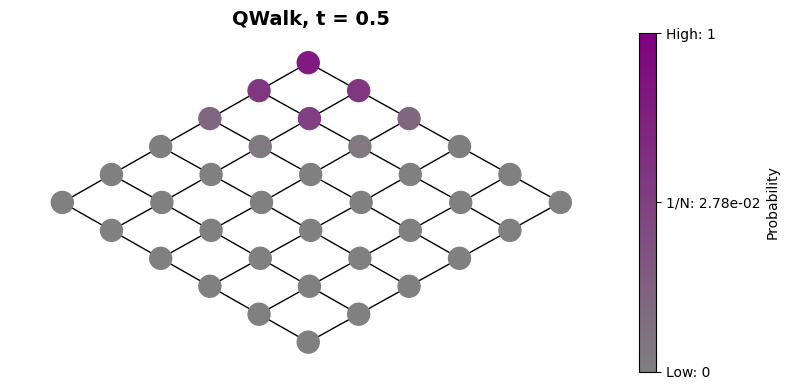

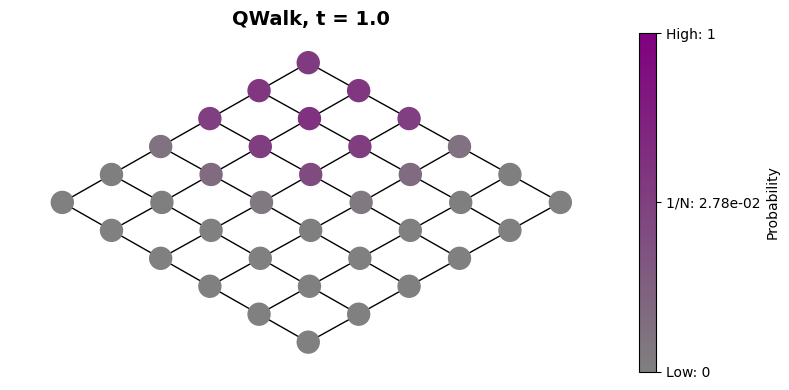

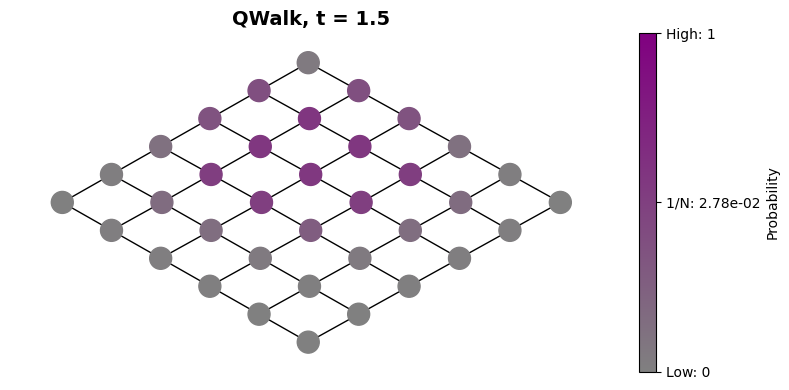

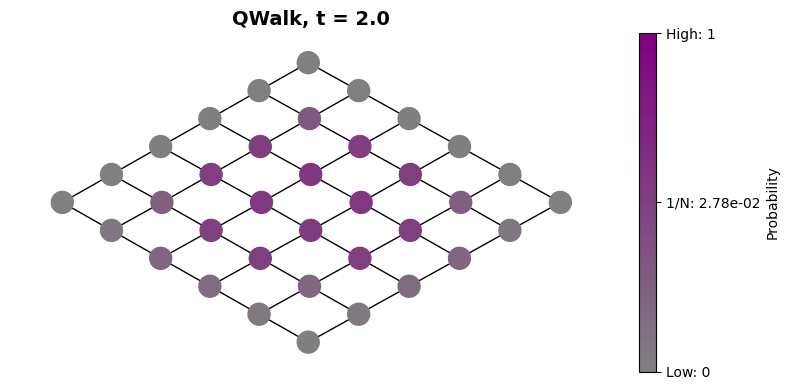

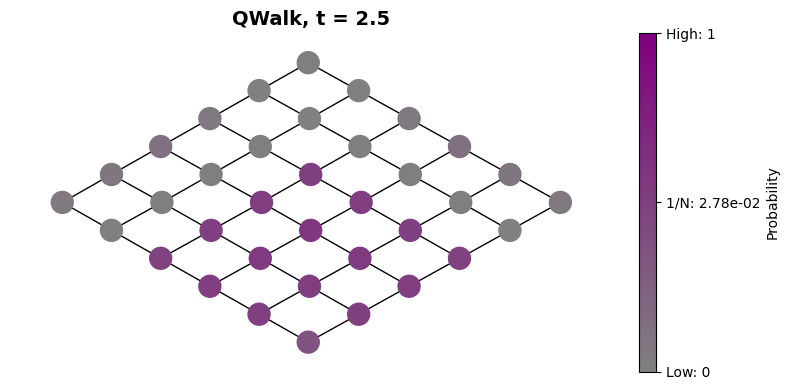

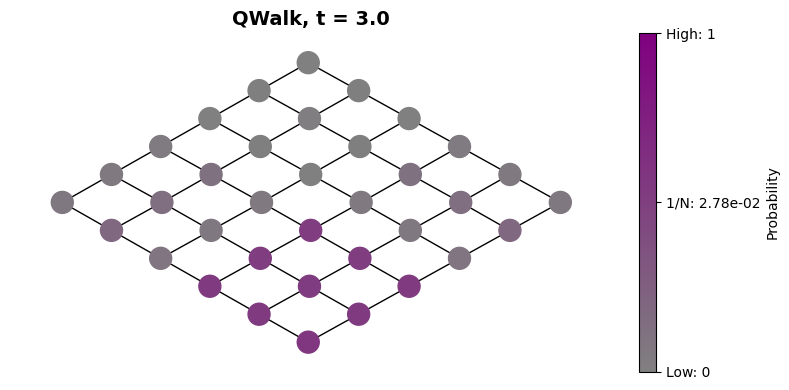

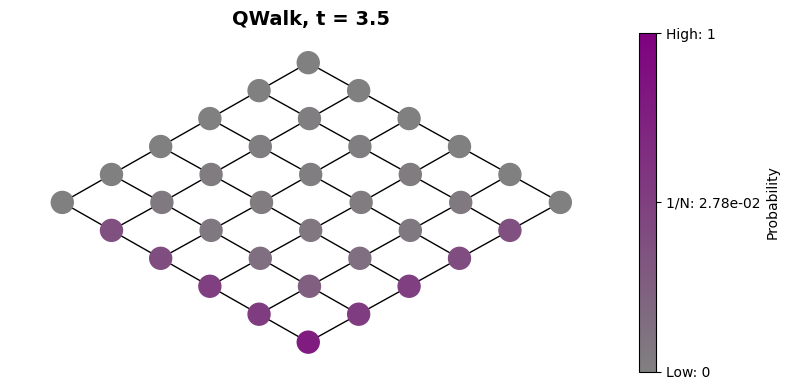

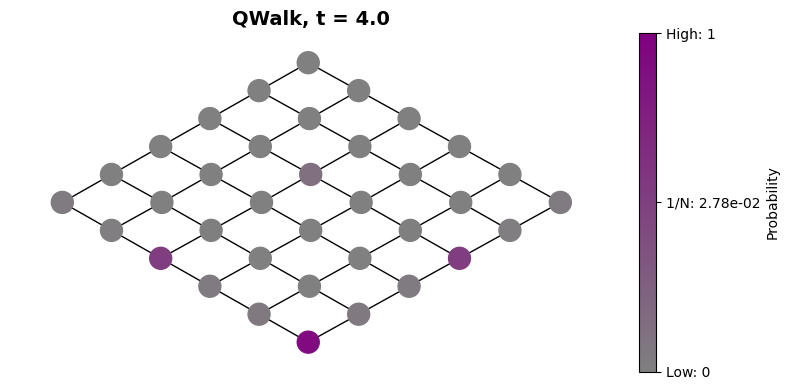

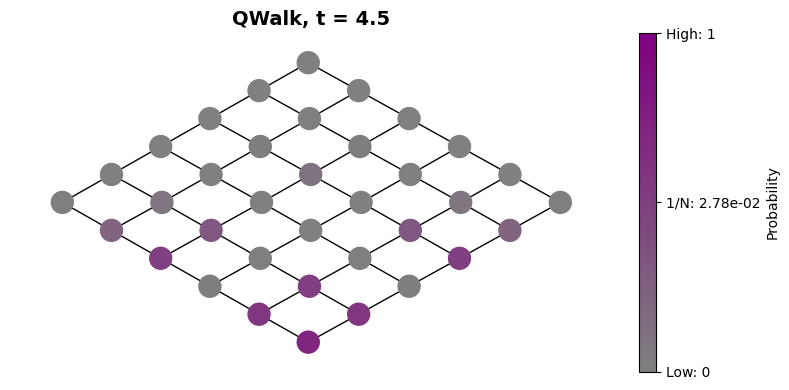

In [29]:
#Playground full of different graphs to choose from

# define any graph you'd like from the networkx library
G1 = nx.hypercube_graph(3)
G2 = nx.cycle_graph(10)
G3 = nx.grid_2d_graph(6, 6)
G4 = nx.balanced_tree(3,3)
G5 = nx.lollipop_graph(8,10)


# We can implement methods to generate graphs of particular interest
wheel_graph = create_wheel_graph(8)
caylay_graph = create_cayley_tree(3,4)

my_graph = G3
#Get the adjacency from nx
Adj = nx.adjacency_matrix(my_graph)

# Initial state vector 
num_nodes = Adj.shape[0]
pos_0 = np.zeros(num_nodes)
pos_0[0] = 1  # Classical initial state
psi_0 = pos_0.copy()  # Quantum initial state

# Time parameters: 
t_n = 0 # Starting time
timestep = 0.5 # step value
n = 10 # Number of steps


for i in range(n):
    # Compute the quantum walk probabilities
    psi_t = quantum_walk(adjacency = Adj, initial_position = psi_0, time_step = t_n)
    prob_quantum = np.abs(psi_t)**2

    str = get_pi_frac(i,16)
    title = f"QWalk, t = {t_n}"
    visualize_probabilities(my_graph,prob_quantum, labels=False, title=title)

    t_n += timestep



### Specific Wheel with D layers graph vis for Dan

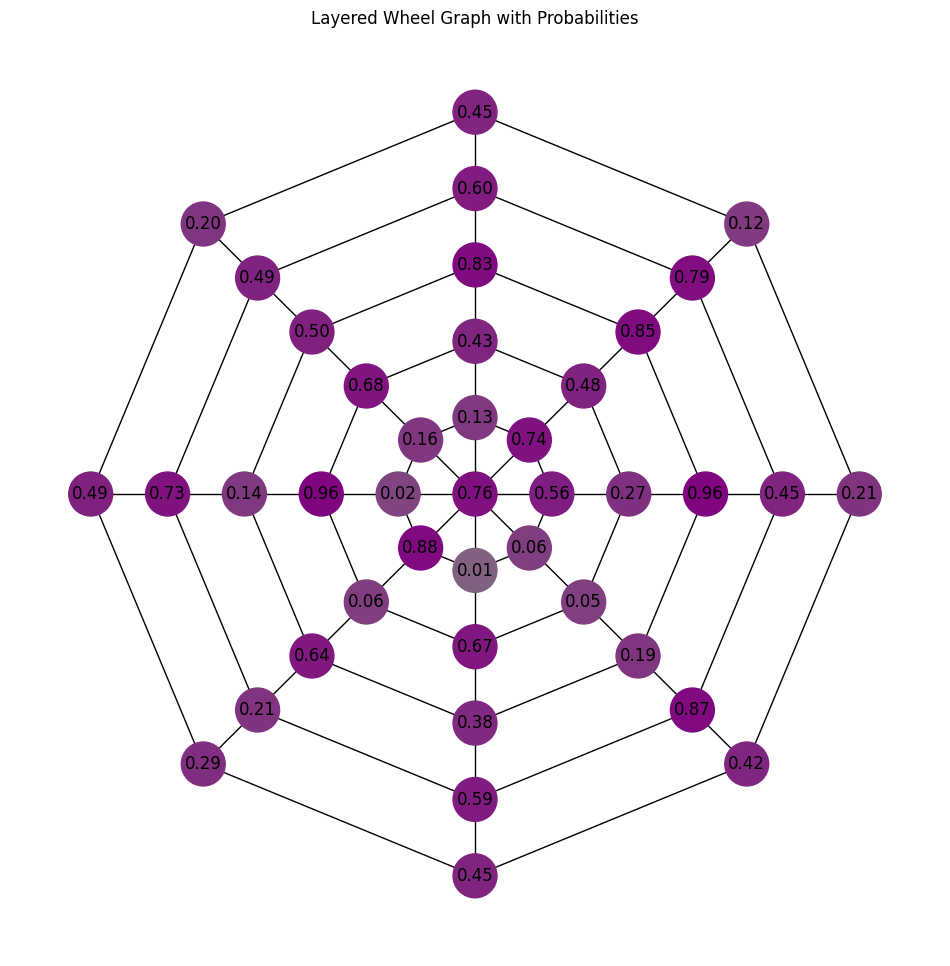

In [30]:
def layered_wheel_graph(n, d):
    G = nx.Graph()
    node_counter = 0  # Initialize node counter

    # Add center node labeled with 0
    center_node = node_counter
    G.add_node(center_node, pos=(0, 0))  # Store position as a node attribute
    node_counter += 1

    prev_layer_nodes = []
    # Build each layer
    for layer in range(1, d + 1):
        layer_nodes = []
        radius = layer * 2  # Adjust spacing between layers if needed
        angle_step = 2 * np.pi / n
        for i in range(n):
            angle = i * angle_step
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            node_label = node_counter  # Label node with the current counter
            G.add_node(node_label, pos=(x, y))  # Store position as a node attribute
            layer_nodes.append(node_label)
            if layer == 1:
                # Connect to center node
                G.add_edge(center_node, node_label)
            else:
                # Connect to the corresponding node in the previous layer
                G.add_edge(prev_layer_nodes[i], node_label)
            node_counter += 1
        # Connect nodes in the current layer in a ring
        for i in range(n):
            G.add_edge(layer_nodes[i], layer_nodes[(i + 1) % n])
        prev_layer_nodes = layer_nodes
    return G

def visualize_probabilities_for_wheel(G, prob_values, start=None, end=None, labels=False, title='', ax=None):
    # Number of nodes
    N = len(G.nodes())
    equal_prob = 1 / N

    # Define a custom colormap from gray to purple
    cmap = LinearSegmentedColormap.from_list('CustomMap', ['gray', 'purple'])

    # Set up normalization with midpoint at equal probability
    norm = TwoSlopeNorm(vmin=0, vcenter=equal_prob, vmax=1)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Map node colors based on probability values
    node_colors = [mapper.to_rgba(prob_values[node]) for node in G.nodes()]

    # Create a new axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()

    # Extract positions from node attributes
    pos = nx.get_node_attributes(G, 'pos')

    # Create labels with probabilities formatted to 2 decimal places
    prob_dict = {node: f'{prob_values[node]:.2f}' for node in G.nodes()}

    # Draw the graph with custom colors and no labels
    nx.draw(
        G,
        pos=pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=False,
        ax=ax
    )

    # Draw probability labels on nodes
    nx.draw_networkx_labels(G, pos, labels=prob_dict, font_color='black', ax=ax)

    # Annotate the start and end nodes if provided
    labels_dict = {}
    label_positions = {}
    offset = 1.4  # Adjust this value to control label distance from the node
    if start is not None and start in G.nodes():
        labels_dict[start] = 'Start'
        x, y = pos[start]
        label_positions[start] = (x + offset , y)  # Offset label position
    if end is not None and end in G.nodes():
        labels_dict[end] = 'Target'
        x, y = pos[end]
        label_positions[end] = (x - offset - 0.4, y)

    if labels_dict:
        nx.draw_networkx_labels(G, label_positions, labels=labels_dict, font_color='red', font_weight='bold', ax=ax)

    # Set the title if provided
    if title:
        ax.set_title(title)

    return ax

# Parameters
n = 8  # Number of nodes in each ring
d = 5  # Number of layers

# Create the layered wheel graph
G = layered_wheel_graph(n, d)

# Create some example probability values for each node
# For demonstration, we'll assign random probabilities to each node
prob_values = {node: np.random.rand() for node in G.nodes()}

# Visualize the graph with probabilities
fig, ax = plt.subplots(figsize=(12, 12))
visualize_probabilities_for_wheel(
    G,
    prob_values=prob_values,
    start=160,
    end=152,
    labels=True,
    title='Layered Wheel Graph with Probabilities',
    ax=ax
)
plt.show()


In [13]:
# Dan's Wheel

wheel_ring = 7
wheel_graph = create_wheel_graph(wheel_ring)
star_graph = nx.star_graph(10)
my_graph = G

# Get the adjacency from nx
Adj = nx.adjacency_matrix(graph)

# Initial state vector
num_nodes = Adj.shape[0]
pos_0 = np.zeros(num_nodes)
pos_0[30] = 1

# Classical initial state

psi_0 = pos_0.copy()  # Quantum initial state

# Time parameters:

is_pi = False
timestep = 0.1  # step value
n = 400  # Number of steps

timestep_str = "1_over_sqrt(10)"
Qwalk = True

# Create a PdfPages object to save plots to a PDF
if Qwalk:
    pdf_filename = f'Off_Center_QWalk_Wheel_Graph_N=16_d=10.pdf'
else:
    pdf_filename = f'Classic_Star_N_{wheel_ring}.pdf'
pdf = PdfPages(pdf_filename)

start_offset = 0

if Qwalk:
    # Quantum Walk Plots
    for i in range(n+1):
        
        if start_offset > 10:
            t_n = i * timestep  # Current time step
        else:
            t_n = timestep
            start_offset += 1
        # Compute the quantum walk probabilities
        psi_t = quantum_walk(adjacency=Adj, initial_position=psi_0, time_step=t_n)
        prob_quantum = np.abs(psi_t)**2
    
        # Get time as fraction of pi
        if is_pi:
            t_str = get_pi_frac(i,b)
            title = f"QWalk, t = {i}/10 * 3/sqrt(10), {t_str}"
        else: 
            title = f"time = {t_n:.2f}"
        # Create a new figure and axis
        fig, ax = plt.subplots(figsize=(14, 7))
    
        # Visualize probabilities
        visualize_probabilities_for_wheel(my_graph, prob_quantum, labels=True, title=title, ax=ax)
    
        # Save the figure to the PDF
        pdf.savefig(fig)
        plt.close(fig)  # Close the figure to free up memory
        
else: 
    # Classical Walk Plots
    for i in range(n):
        t_n = i/2 * timestep  # Current time step
    
        # Compute the classical walk probabilities
        pos_t = classical_random_walk(adjacency=Adj, initial_position=pos_0, time_step=t_n)
    
        # Get time as fraction of pi
        if is_pi:
            t_str = get_pi_frac(i,b)
            title = f"Classic Walk, t = t = {i}/pi * 1/pi*sqrt(10), {t_str}"
        else: 
            title = f"Classic Walk, t = {i} * 1/5 ({t_n:.4f})"
    
        # Create a new figure and axis
        fig, ax = plt.subplots(figsize=(8, 4))
    
        # Visualize probabilities
        visualize_probabilities_for_wheel(my_graph, pos_t, labels=False, title=title, ax=ax)
    
        # Save the figure to the PDF
        pdf.savefig(fig)
        plt.close(fig)  # Close the figure

# Close the PdfPages object
pdf.close()

print(f"All plots have been saved to {pdf_filename}")


All plots have been saved to Off_Center_QWalk_Wheel_Graph_N=16_d=10.pdf


### Spesific 'Directed' Wheel for Dan

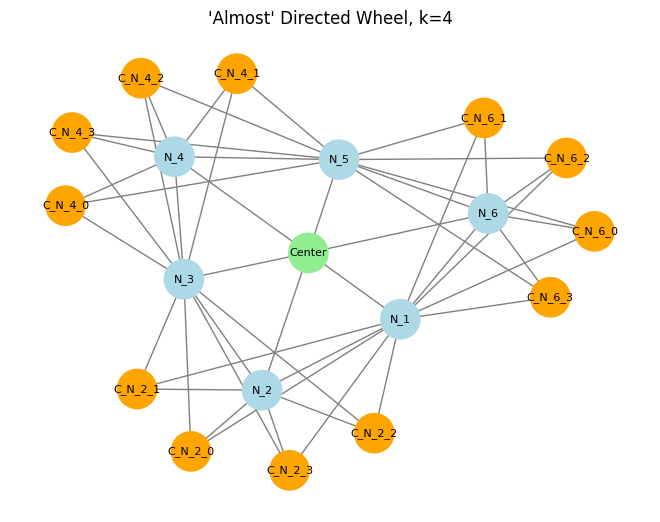

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an undirected graph
G = nx.Graph()

# Define the central node and outer nodes
central_node = 'Center'
outer_nodes = [f'N_{i}' for i in range(1, 7)]

# Add the central node and outer nodes to the graph
G.add_node(central_node)
G.add_nodes_from(outer_nodes)

# Connect the center node to nodes 1, 3, and 5
for node in ['N_1', 'N_3', 'N_5']:
    G.add_edge(central_node, node)

# Connect the center node to nodes 2, 4, and 6
for node in ['N_2', 'N_4', 'N_6']:
    G.add_edge(central_node, node)

# Connect outer nodes in a cycle
cycle_edges = [
    ('N_1', 'N_2'),
    ('N_2', 'N_3'),
    ('N_3', 'N_4'),
    ('N_4', 'N_5'),
    ('N_5', 'N_6'),
    ('N_6', 'N_1')
]
G.add_edges_from(cycle_edges)

# Neighbor mapping for nodes 2, 4, and 6
neighbor_map = {
    'N_2': ['N_1', 'N_3'],
    'N_4': ['N_3', 'N_5'],
    'N_6': ['N_5', 'N_1']
}

k = 4
# For nodes 2, 4, and 6, add unique helper nodes and edges
for node in ['N_2', 'N_4', 'N_6']:
    # Create k unique helper nodes for each node
    helper_nodes = [f'C_{node}_{i}' for i in range(k)]
    G.add_nodes_from(helper_nodes)
    
    # Connect the main node to its helper nodes
    for helper_node in helper_nodes:
        G.add_edge(node, helper_node)
    
    # Connect the helper nodes to the neighboring nodes of the main node
    neighbors = neighbor_map[node]
    for helper_node in helper_nodes:
        for neighbor in neighbors:
            G.add_edge(helper_node, neighbor)

# Assign colors to nodes: real nodes are blue, helper nodes are orange, center is green
node_colors = []
for node in G.nodes():
    if node.startswith('C_'):
        node_colors.append('orange')  # Helper nodes
    elif node == central_node:
        node_colors.append('lightgreen')  # Central node
    else:
        node_colors.append('lightblue')  # Real nodes

# Draw the graph
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_color='gray',
    node_size=800,
    font_size=8
)
plt.title(f'\'Almost\' Directed Wheel, k={k}')
plt.show()


In [17]:
def visualize_probabilities_for_directed_wheel(G, prob_values, labels=False, title='', ax=None):
    import matplotlib.cm as cm
    from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

    # Number of nodes
    N = len(G.nodes())
    equal_prob = 1 / N

    # Define a custom colormap from gray to purple
    cmap = LinearSegmentedColormap.from_list('CustomMap', ['gray', 'purple'])

    # Set up normalization with midpoint at equal probability
    norm = TwoSlopeNorm(vmin=0, vcenter=equal_prob, vmax=max(prob_values.values()))
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Map node colors based on probability values
    node_colors = [mapper.to_rgba(prob_values[node]) for node in G.nodes()]

    # Create a new axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.get_figure()

    # Generate positions for nodes
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph with custom colors
    nx.draw(
        G,
        pos=pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=False,  # Turn off default labels
        edge_color='gray',
        ax=ax
    )

    if labels:
        # Create labels with probabilities formatted to 2 decimal places
        labels_dict = {node: f'{prob_values[node]:.3g}' for node in G.nodes()}

        # Draw labels at node positions
        nx.draw_networkx_labels(
            G,
            pos=pos,
            labels=labels_dict,
            font_size=8,
            font_color='black',
            font_weight='bold',
            ax=ax
        )

    # Add color bar with intermediate ticks
    cbar = plt.colorbar(mapper, ax=ax, label="Probability", fraction=0.046, pad=0.04)
    cbar.set_ticks([0, equal_prob, max(prob_values.values())])
    cbar.set_ticklabels([f"Low: 0", f"1/N: {equal_prob:.2f}", f"High: {max(prob_values.values()):.2f}"])

    # Set title if provided
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')

    # Remove axis for better layout control
    ax.axis('off')

### Create an animation based params: 


In [ ]:
# Dan's Wheel
my_graph = G
nodes = list(my_graph.nodes())

# Get the adjacency matrix from nx with specified node order
Adj = nx.adjacency_matrix(my_graph, nodelist=nodes)

# Initial state vector
num_nodes = Adj.shape[0]
pos_0 = np.zeros(num_nodes)
pos_0[0] = 1  # Assuming the starting node is at index 0

# Quantum initial state
psi_0 = pos_0.copy()

# Time parameters
timestep = 0.05  # Step value
n = 600         # Number of steps

# Create a folder to save images
folder_name = 'quantum_walk_frames'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# List to store the filenames of the saved images
image_files = []
start_offset = 0
# Quantum Walk Plots
for i in range(n + 1):
    
    if start_offset > 10:
        t_n = i * timestep  # Current time step
    else:
        t_n = 0
        start_offset += 1

    #Compute the quantum walk probabilities
    # psi_t = quantum_walk(adjacency=Adj, initial_position=psi_0, time_step=t_n)
    # prob_quantum = np.abs(psi_t) ** 2
    # 
    # # Map probabilities to node labels
    # prob_quantum_dict = {nodes[i]: prob_quantum[i] for i in range(len(nodes))}



    classic_prob = classical_random_walk(adjacency=Adj, initial_position=psi_0, time_step=t_n)
    prob_classic_dict = {nodes[i]: classic_prob[i] for i in range(len(nodes))}
    title = f"Random Walk, t = {t_n:.2f}"

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(14, 7))

    # Visualize probabilities
    visualize_probabilities_for_wheel(
        my_graph, classic_prob, labels=True, title=title,start=40, ax=ax
    )

    # Save the figure as an image file
    filename = f"{folder_name}/frame_{i:03d}.png"
    plt.savefig(filename)
    plt.close(fig)  # Close the figure to free up memory

    # Append the filename to the list
    image_files.append(filename)

print(f"All plots have been saved to the folder '{folder_name}'.")

# Parameters for the video
video_filename = f'animation_classical_n=8_k=5.mp4'
fps = 20  # Frames per second

# Read images and write to video
with imageio.get_writer(video_filename, fps=fps) as video_writer:
    for filename in image_files:
        image = imageio.imread(filename)
        video_writer.append_data(image)

print(f"Video has been saved as '{video_filename}'.")


### Directed Quantum Walks Approximation Matrix

In [32]:
def create_layered_wheel_graph(n, d, directed=False):
    """
    Create a layered wheel graph with 'n' nodes per layer and 'd' layers.
    If 'directed' is True, the graph will be directed as per the specified rules.
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    node_counter = 0  # Initialize node counter

    # Add center node labeled with 0
    center_node = node_counter
    G.add_node(center_node, pos=(0, 0))  # Store position as a node attribute
    node_counter += 1

    prev_layer_nodes = []
    # Build each layer
    for layer in range(1, d + 1):
        layer_nodes = []
        radius = layer * 2  # Adjust spacing between layers if needed
        angle_step = 2 * np.pi / n
        for i in range(n):
            angle = i * angle_step
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            node_label = node_counter  # Label node with the current counter
            G.add_node(node_label, pos=(x, y))  # Store position as a node attribute
            layer_nodes.append(node_label)
            if layer == 1:
                # Connect to center node
                if directed:
                    G.add_edge(center_node, node_label)  # Edge from center to peripheral
                else:
                    G.add_edge(center_node, node_label)
            else:
                # Connect to the corresponding node in the previous layer
                if directed:
                    G.add_edge(prev_layer_nodes[i], node_label)  # Edge from inner to outer layer
                else:
                    G.add_edge(prev_layer_nodes[i], node_label)
            node_counter += 1
        # Connect nodes in the current layer in a ring
        for i in range(n):
            if directed:
                G.add_edge(layer_nodes[i], layer_nodes[(i + 1) % n])  # One-way edge in the cycle
            else:
                G.add_edge(layer_nodes[i], layer_nodes[(i + 1) % n])
        prev_layer_nodes = layer_nodes
    return G

def visualize_probabilities(G, prob_values, start=None, end=None, labels=False, title='', ax=None):
    """
    Visualize the graph 'G' with node probabilities 'prob_values'.
    Supports both directed and undirected graphs.
    """
    N = len(G.nodes())
    equal_prob = 1 / N

    # Define a custom colormap from gray to purple
    cmap = LinearSegmentedColormap.from_list('CustomMap', ['gray', 'purple'])

    # Set up normalization with midpoint at equal probability
    norm = TwoSlopeNorm(vmin=0, vcenter=equal_prob, vmax=1)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    # Map node colors based on probability values
    node_colors = [mapper.to_rgba(prob_values[node]) for node in G.nodes()]

    # Create a new axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()

    # Extract positions from node attributes
    pos = nx.get_node_attributes(G, 'pos')

    # Create labels with probabilities formatted to 2 decimal places
    prob_dict = {node: f'{prob_values[node]:.2f}' for node in G.nodes()}
    
    node_size = 1300
    
    # Draw the graph
    if G.is_directed():
        nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=node_size, ax=ax)
        nx.draw_networkx_labels(G, pos=pos, labels=prob_dict, font_color='black', ax=ax)
        nx.draw_networkx_edges(
        G,
        pos=pos,
        arrowstyle='-|>, head_length=0.8, head_width=0.3', # Custom arrow style
        arrowsize=15,      # Increase to make arrowhead larger
        width=1.5,           # Optional: make edges thicker
        connectionstyle='arc3,rad=0.1',  # Optional: add slight curvature
        ax=ax
    )
    else:
        nx.draw(
            G,
            pos=pos,
            node_color=node_colors,
            node_size=node_size,
            with_labels=False,
            ax=ax
        )
        nx.draw_networkx_labels(G, pos=pos, labels=prob_dict, font_color='black', ax=ax)

    # Annotate the start and end nodes if provided
    labels_dict = {}
    label_positions = {}
    offset = 1.4  # Adjust this value to control label distance from the node
    if start is not None and start in G.nodes():
        labels_dict[start] = 'Start'
        x, y = pos[start]
        label_positions[start] = (x + offset, y)  # Offset label position
    if end is not None and end in G.nodes():
        labels_dict[end] = 'Target'
        x, y = pos[end]
        label_positions[end] = (x - offset - 0.4, y)

    if labels_dict:
        nx.draw_networkx_labels(G, label_positions, labels=labels_dict, font_color='red', font_weight='bold', ax=ax)

    # Set the title if provided
    if title:
        ax.set_title(title, y=0.95, fontsize=16)

    return ax

In [33]:

# Parameters
n = 8  # Number of nodes in each ring
d = 5  # Number of layers
start_node = 0  # Starting node index

# Output mode: 'pdf' or 'animation'
output_mode = 'pdf'  # Set to 'animation' for video output

# Create both undirected and directed layered wheel graphs
G_undirected = create_layered_wheel_graph(n, d, directed=False)
G_directed = create_layered_wheel_graph(n, d, directed=True)

nodes = list(G_directed.nodes())

# Get adjacency matrices
Adj_undirected = nx.adjacency_matrix(G_undirected, nodelist=nodes).astype(float)
Adj_directed = nx.adjacency_matrix(G_directed, nodelist=nodes).astype(float)

# Create Hermitian Hamiltonians
H_undirected = Adj_undirected  # For undirected graph, adjacency matrix is symmetric
S_directed = Adj_directed - Adj_directed.T
H_directed = 1j * S_directed

# Initial state vector
num_nodes = Adj_directed.shape[0]
psi_0 = np.zeros(num_nodes, dtype=complex)
psi_0[start_node] = 1

# Time parameters
timestep = 0.1  # Step value
n_steps = 100  # Number of steps

# Output folder
output_folder = './comparison_outputs'
os.makedirs(output_folder, exist_ok=True)

# Create a 'frames' subdirectory within the output folder
frames_folder = os.path.join(output_folder, 'frames')
os.makedirs(frames_folder, exist_ok=True)

if output_mode == 'animation':
    # List to store the filenames of the saved images
    image_files = []

    # Quantum Walk Plots
    for i in range(n_steps + 1):
        t_n = i * timestep  # Current time step

        # Compute the quantum walk probabilities for undirected graph
        psi_t_undirected = quantum_walk(H_undirected, psi_0, t_n)
        prob_quantum_undirected = np.abs(psi_t_undirected)**2
        prob_quantum_undirected_dict = {nodes[j]: prob_quantum_undirected[j] for j in range(len(nodes))}

        # Compute the quantum walk probabilities for directed graph
        psi_t_directed = quantum_walk(H_directed, psi_0, t_n)
        prob_quantum_directed = np.abs(psi_t_directed)**2
        prob_quantum_directed_dict = {nodes[j]: prob_quantum_directed[j] for j in range(len(nodes))}

        # Create a new figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(24, 12))

        # Visualize probabilities on the undirected graph
        title_undirected = f"Undirected Graph, t = {t_n:.2f}"
        visualize_probabilities(
            G_undirected, prob_quantum_undirected_dict, labels=False, title=title_undirected, ax=axes[0]
        )

        # Visualize probabilities on the directed graph
        title_directed = f"'Directed' Graph, t = {t_n:.2f}"
        visualize_probabilities(
            G_directed, prob_quantum_directed_dict, labels=False, title=title_directed, ax=axes[1]
        )

        # Adjust layout and save the figure as an image file
        plt.tight_layout()
        filename = os.path.join(frames_folder, f'frame_{i:03d}.png')
        plt.savefig(filename)
        plt.close(fig)  # Close the figure to free up memory

        # Append the filename to the list
        image_files.append(filename)

    print(f"All frames have been saved to the folder '{frames_folder}'.")

    # Parameters for the video
    video_filename = os.path.join(output_folder, f'comparison_animation_n={n}_d={d}_start={start_node}.mp4')
    fps = 10  # Frames per second

    # Read images and write to video
    with imageio.get_writer(video_filename, fps=fps) as video_writer:
        for filename in image_files:
            image = imageio.imread(filename)
            video_writer.append_data(image)

    print(f"Video has been saved as '{video_filename}'.")

elif output_mode == 'pdf':
    # Create a PdfPages object to save plots to a PDF
    pdf_filename = os.path.join(output_folder, 'Quantum_Walk_Comparison.pdf')
    pdf = PdfPages(pdf_filename)

      # Add the explanation on the first page
    fig_explanation = plt.figure(figsize=(8.5, 11))  # Standard letter size

    explanation_text = """
    Simulating a 'directed' graph:

    We tried to create a Hermitian matrix that would still include some 'directness' information.
    A way to get this Hermitian matrix is to subtract the transpose and multiply by i:

    M = Adjacency matrix
    S = M - M^T
    H = i * S

    H is Hermitian because H† = H.

    Here is an example of a simple directed graph matrix:
    [0,1,0
     0,0,0
     0,0,0]
    and here is how it will look with this trick:
    [0,i,0
     -i,0,0
     0,0,0]

    We hoped that by running this walk the evolution would at least somewhat follow the directed structure, but unfortunately it doesn't.
    This new matrix, however, still introduces some asymmetry which I am sure has beautiful math behind it.
    It is still interesting to consider if there is some way to extract information out of this matrix, we will try to see if we can analyze
    this matrix and perhaps get some value out of it.

    Below is a comparison between the quantum walks on the undirected and the 'directed' graphs.
    """

    # Create an axes to place the text
    ax = fig_explanation.add_axes([0.02, 0.1, 0.8, 0.8])
    ax.axis('off')  # Hide the axes

    # Add the text
    ax.text(0, 1, explanation_text, fontsize=12, va='top', ha='left', wrap=True)

    pdf.savefig(fig_explanation)
    plt.close(fig_explanation)

    # Quantum Walk Plots
    for i in range(n_steps + 1):
        t_n = i * timestep  # Current time step

        # Compute the quantum walk probabilities for undirected graph
        psi_t_undirected = quantum_walk(H_undirected, psi_0, t_n)
        prob_quantum_undirected = np.abs(psi_t_undirected)**2
        prob_quantum_undirected_dict = {nodes[j]: prob_quantum_undirected[j] for j in range(len(nodes))}

        # Compute the quantum walk probabilities for directed graph
        psi_t_directed = quantum_walk(H_directed, psi_0, t_n)
        prob_quantum_directed = np.abs(psi_t_directed)**2
        prob_quantum_directed_dict = {nodes[j]: prob_quantum_directed[j] for j in range(len(nodes))}

        # Create a new figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(24, 12))

        # Visualize probabilities on the undirected graph
        title_undirected = f"Undirected Graph, t = {t_n:.2f}"
        visualize_probabilities(
            G_undirected, prob_quantum_undirected_dict, labels=False, title=title_undirected, ax=axes[0]
        )

        # Visualize probabilities on the directed graph
        title_directed = f"Directed Graph, t = {t_n:.2f}"
        visualize_probabilities(
            G_directed, prob_quantum_directed_dict, labels=False, title=title_directed, ax=axes[1]
        )

        # Adjust layout and save the figure to the PDF
        plt.tight_layout()
        pdf.savefig(fig)

        # Also save the frame as an image in the frames folder
        filename = os.path.join(frames_folder, f'frame_{i:03d}.png')
        plt.savefig(filename)
        plt.close(fig)  # Close the figure to free up memory

    # Close the PdfPages object
    pdf.close()
    print(f"All plots have been saved to {pdf_filename}")
    print(f"All frames have been saved to the folder '{frames_folder}'.")

else:
    print("Invalid output_mode. Please set it to 'pdf' or 'animation'.")

All plots have been saved to ./comparison_outputs/Quantum_Walk_Comparison.pdf
All frames have been saved to the folder './comparison_outputs/frames'.
